In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Optional for advanced filtering — install scipy if you want to use this
try:
    from scipy.signal import medfilt
except ImportError:
    print("Warning: scipy not installed, median filter won't be available.")
    medfilt = None

# ✅ Ensure export folders exist
figures_dir = '/Users/alistairblair/AX08_Project/figures'
data_dir = '/Users/alistairblair/AX08_Project/cleaned_profiles'

os.makedirs(figures_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# Save cleaned profiles
for df in cleaned_profiles:
    profile_name = df['Profile'].iloc[0].replace('.txt', '_cleaned.csv')
    df.to_csv(os.path.join(data_dir, profile_name), index=False)

# Save metadata
metadata_df = pd.DataFrame(meta_list)
metadata_df.to_csv(os.path.join(data_dir, 'cleaned_profiles_metadata.csv'), index=False)

# Optional: Save all cleaned profiles into a single CSV
combined_df = pd.concat(cleaned_profiles, ignore_index=True)
combined_df.to_csv(os.path.join(data_dir, 'all_cleaned_profiles_combined.csv'), index=False)

In [38]:
# Folder containing your XBT .txt files
ascii_folder = '/Users/alistairblair/AX08_Project/Logs, summary and report/ascii'

# List all .txt files
txt_files = [f for f in os.listdir(ascii_folder) if f.endswith('.txt')]

print(f"Found {len(txt_files)} profile files")

Found 517 profile files


In [32]:
def parse_lat(lat_str):
    """Convert lat string like '33 47.86  N' to decimal degrees."""
    parts = lat_str.strip().split()
    deg = float(parts[0])
    minute = float(parts[1])
    sign = -1 if parts[2].upper() == 'S' else 1
    return sign * (deg + minute / 60)

profiles = []
meta_list = []

for file in txt_files:
    path = os.path.join(ascii_folder, file)
    with open(path, 'r') as f:
        lines = f.readlines()

    meta = {'file': file}
    start_index = None
    for idx, line in enumerate(lines):
        if "Date" in line and "Time" in line:
            meta['Date'] = line.split(',')[0].split('=')[1].strip()
        if "Latitude" in line and "Longitude" in line:
            lat_str = line.split(',')[0].split('=')[1].strip()
            lon_str = line.split(',')[1].split('=')[1].strip()
            meta['Latitude_str'] = lat_str
            meta['Longitude_str'] = lon_str
            meta['Latitude'] = parse_lat(lat_str)
        if "Full Resolution Values" in line:
            start_index = idx + 2  # Data starts 2 lines below this
            break

    if start_index is None:
        print(f"Warning: No data found in file {file}")
        continue

    # Read profile data from string block
    data_str = ''.join(lines[start_index:])
    from io import StringIO  # Make sure this is at the top of your notebook or script

    df = pd.read_csv(StringIO(data_str), sep=r',\s*', engine='python', names=['Depth', 'Temp'])
    # Store raw profile & metadata
    df['Profile'] = file
    df['Latitude'] = meta['Latitude']

    profiles.append(df)
    meta_list.append(meta)

In [33]:
import numpy as np
import pandas as pd
from scipy.signal import medfilt

# --- Configuration ---
TEMP_RANGE = (-2, 40)
DEPTH_RANGE = (0, 2000)
MAX_GRADIENT = 0.08
SPIKE_DIFF_THRESHOLD = 3.0
ROLLING_DEV_THRESHOLD = 2.5
ROLLING_WINDOW = 11
SPIKE_ZONE = (600, 850)
SPIKE_ZONE_DEV_THRESHOLD = 1.5
FLAT_SEGMENT_THRESHOLD = 0.8
STEEP_MEDIAN_GRADIENT = 0.1
MAX_DEPTH_DIFF = 10  # from EP2022-1825: max acceptable depth interval

# --- Utility Cleaning Functions ---

def is_monotonic(df):
    return (df['Depth'].diff().dropna() > 0).all()

def min_valid_profile(df, min_points=15):
    return len(df) >= min_points

def remove_missing(df):
    return df.dropna()

def remove_out_of_range(df):
    return df[
        (df['Temp'] >= TEMP_RANGE[0]) & (df['Temp'] <= TEMP_RANGE[1]) &
        (df['Depth'] >= DEPTH_RANGE[0]) & (df['Depth'] <= DEPTH_RANGE[1])
    ]

def remove_low_resolution(df, max_step=MAX_DEPTH_DIFF):
    depth_diff = df['Depth'].diff()
    if depth_diff.max() > max_step:
        return None
    return df

def remove_local_spikes(df):
    df['diff_prev'] = df['Temp'].diff().abs()
    df['diff_next'] = df['Temp'].diff(-1).abs()
    mask = (
        (df['diff_prev'] < SPIKE_DIFF_THRESHOLD) | df['diff_prev'].isna()
    ) & (
        (df['diff_next'] < SPIKE_DIFF_THRESHOLD) | df['diff_next'].isna()
    )
    return df[mask].drop(columns=['diff_prev', 'diff_next'])

def remove_flat_segments(df, tolerance=0.05):
    temp_diff = df['Temp'].diff()
    long_flat = temp_diff.abs().rolling(window=5).sum() < tolerance
    return df[~long_flat.fillna(False)]

def remove_sudden_horizontal_spikes(df):
    df['temp_grad'] = df['Temp'].diff() / df['Depth'].diff()
    df = df[(df['temp_grad'].isna()) | (df['temp_grad'] <= MAX_GRADIENT)]
    return df.drop(columns=['temp_grad'])

def remove_excessive_gradient(df):
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    return df[(gradient.isna()) | (gradient <= MAX_GRADIENT)]

def remove_spikes_in_zone(df):
    in_zone = df['Depth'].between(*SPIKE_ZONE)
    rolling_median = df.loc[in_zone, 'Temp'].rolling(window=7, center=True).median()
    deviation = (df.loc[in_zone, 'Temp'] - rolling_median).abs()
    good_points = (deviation < SPIKE_ZONE_DEV_THRESHOLD) | deviation.isna()
    return df.drop(index=df.loc[in_zone].index[~good_points])

def remove_long_constant_temp(df, max_const_length=20):
    repeat_lengths = (df['Temp'].round(2).diff() != 0).astype(int).cumsum()
    max_run = repeat_lengths.value_counts().max()
    if max_run >= max_const_length:
        return None
    return df

def apply_median_filter(df):
    if len(df) >= 7:
        df['Temp'] = medfilt(df['Temp'], kernel_size=7)
    return df

def remove_global_outliers(df):
    rolling_median = df['Temp'].rolling(window=ROLLING_WINDOW, center=True).median()
    deviation = (df['Temp'] - rolling_median).abs()
    return df[(deviation < ROLLING_DEV_THRESHOLD) | deviation.isna()]

def enforce_physical_gradient(df):
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    keep = (gradient.isna()) | (gradient <= MAX_GRADIENT)
    relaxed = df['Depth'] > 800
    keep_bottom = (gradient[relaxed] <= 0.3) | (gradient[relaxed].isna())
    keep.loc[relaxed] = keep_bottom.values
    return df[keep]

def remove_surface_inversion(df, threshold=0.5):
    """Reject if surface warming > threshold (°C) compared to 10–20 m."""
    surface_temp = df.loc[df['Depth'] <= 5, 'Temp'].mean()
    deeper_temp = df.loc[(df['Depth'] >= 10) & (df['Depth'] <= 20), 'Temp'].mean()
    if pd.notna(surface_temp) and pd.notna(deeper_temp) and (surface_temp - deeper_temp > threshold):
        return None
    return df

# --- Main Cleaning Function ---

def clean_profile(df):
    df = df.copy()

    if not is_monotonic(df):
        return None

    df = remove_missing(df)
    df = remove_out_of_range(df)
    df = remove_low_resolution(df)
    if df is None:
        return None

    df = remove_surface_inversion(df)
    if df is None:
        return None

    df = remove_local_spikes(df)
    df = remove_flat_segments(df)
    df = remove_sudden_horizontal_spikes(df)
    df = remove_excessive_gradient(df)
    df = remove_spikes_in_zone(df)
    df = apply_median_filter(df)
    df = remove_global_outliers(df)
    df = enforce_physical_gradient(df)
    df = remove_long_constant_temp(df)
    if df is None:
        return None

    df = df.reset_index(drop=True)

    # Clip deep temps to account for bottom strike
    df.loc[df['Depth'] > 800, 'Temp'] = df.loc[df['Depth'] > 800, 'Temp'].clip(upper=20)
    if (df.loc[df['Depth'] > 800, 'Temp'] > 22).any():
        return None

    flat_segments = df['Temp'].diff().abs() < 0.05
    if flat_segments.sum() / len(df) > FLAT_SEGMENT_THRESHOLD:
        return None

    median_gradient = (df['Temp'].diff() / df['Depth'].diff()).median()
    if pd.notna(median_gradient) and median_gradient > STEEP_MEDIAN_GRADIENT:
        return None

    if not min_valid_profile(df):
        return None

    return df

# --- Apply to All Profiles ---

cleaned_profiles = []
for df in profiles:
    cleaned = clean_profile(df)
    if cleaned is not None:
        cleaned_profiles.append(cleaned)

# Attach Latitude info to each cleaned profile
for df, meta in zip(cleaned_profiles, meta_list):
    df['Latitude'] = meta['Latitude']

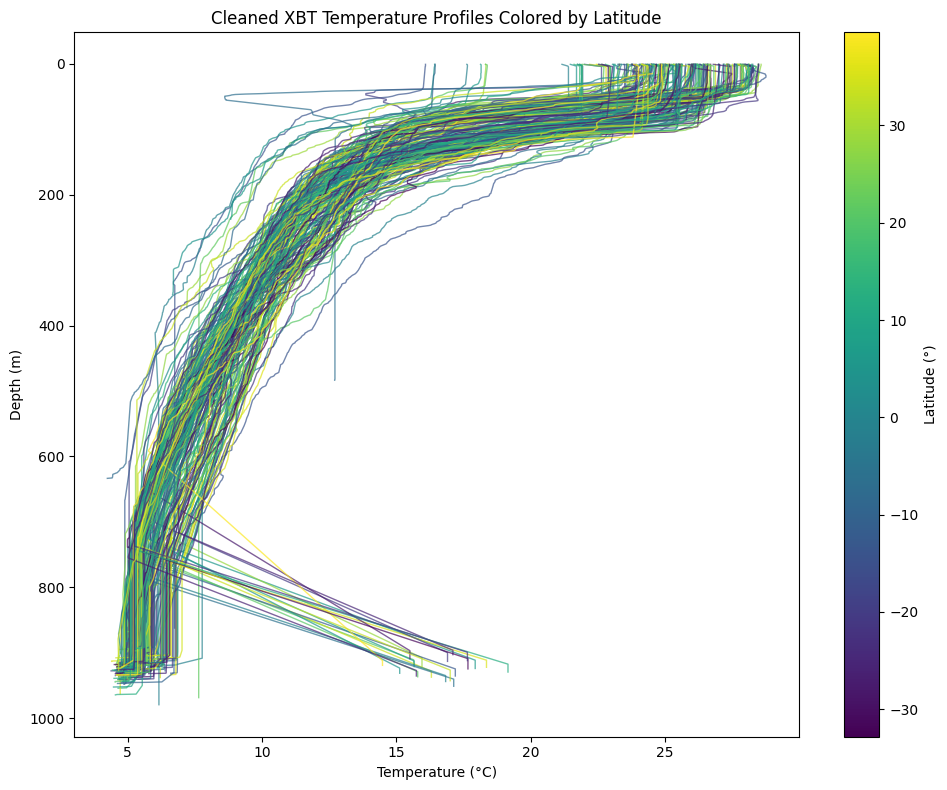

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

latitudes = [df['Latitude'].iloc[0] for df in cleaned_profiles]
norm = mcolors.Normalize(vmin=min(latitudes), vmax=max(latitudes))
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(10, 8))

for df in cleaned_profiles:
    lat = df['Latitude'].iloc[0]
    color = cmap(norm(lat))
    ax.plot(df['Temp'], df['Depth'], color=color, linewidth=1, alpha=0.7)

ax.invert_yaxis()
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Depth (m)')
ax.set_title('Cleaned XBT Temperature Profiles Colored by Latitude')

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Latitude (°)')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'cleaned_xbt_profiles_by_latitude.png'), dpi=300)
plt.show()

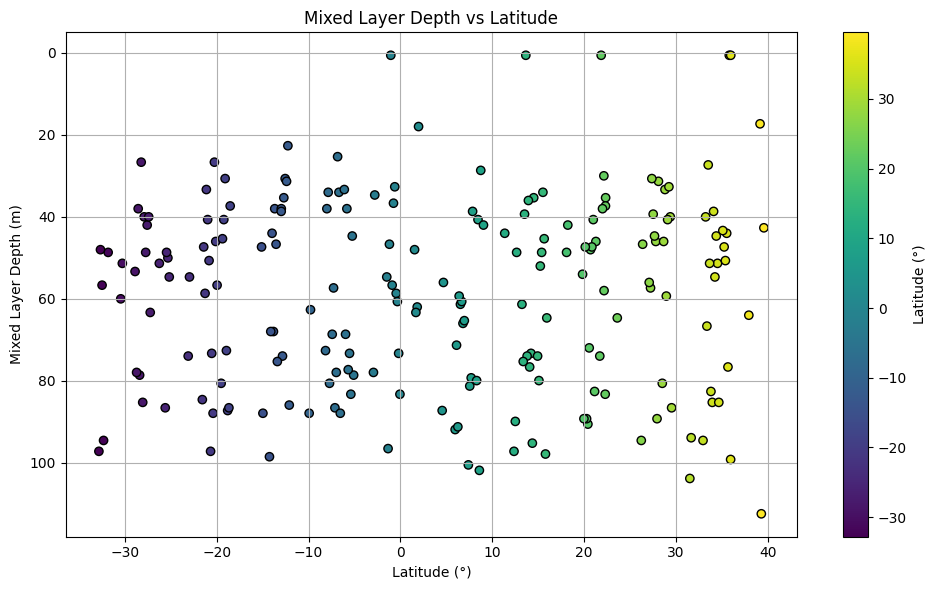

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Settings ---
mld_threshold = 0.5  # °C difference from surface
mld_list = []

# --- Compute MLD from cleaned profiles ---
for df in cleaned_profiles:
    profile_name = df['Profile'].iloc[0]
    lat = df['Latitude'].iloc[0]
    
    shallow = df[df['Depth'] <= 10]
    if shallow.empty:
        continue
    
    surface_temp = shallow['Temp'].mean()

    # Find first depth where temp drops 0.5°C from surface
    mld_candidates = df[df['Temp'] <= surface_temp - mld_threshold]
    
    if not mld_candidates.empty:
        mld_depth = mld_candidates.iloc[0]['Depth']
        mld_list.append({'Latitude': lat, 'MLD': mld_depth, 'Profile': profile_name})
    else:
        # No MLD found in profile
        continue

# --- Create DataFrame ---
mld_df = pd.DataFrame(mld_list)

# --- Plot: MLD vs Latitude ---
plt.figure(figsize=(10, 6))
plt.scatter(mld_df['Latitude'], mld_df['MLD'], c=mld_df['Latitude'], cmap='viridis', edgecolor='k')
plt.xlabel("Latitude (°)")
plt.ylabel("Mixed Layer Depth (m)")
plt.title("Mixed Layer Depth vs Latitude")
plt.gca().invert_yaxis()
plt.colorbar(label="Latitude (°)")
plt.grid(True)
plt.tight_layout()

# --- Save plot ---
plot_path = os.path.join(figures_dir, 'mld_vs_latitude.png')
plt.savefig(plot_path, dpi=300)
plt.show()

# --- Save data ---
mld_df.to_csv(os.path.join(data_dir, 'mld_data.csv'), index=False)

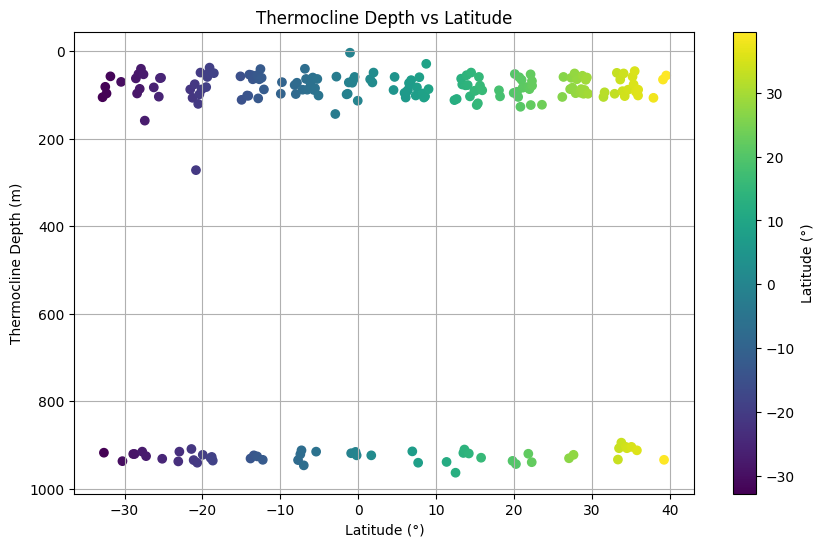

In [47]:
import matplotlib.pyplot as plt

# --- Thermocline detection and plotting ---

thermocline_data = []

for df in cleaned_profiles:
    # Ensure the DataFrame is sorted
    df = df.sort_values('Depth').reset_index(drop=True)
    
    # Calculate vertical gradient
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    gradient = temp_diff / depth_diff
    
    # Find depth of maximum gradient (i.e. steepest negative slope)
    if gradient.isnull().all():
        continue  # skip if all values are NaN

    max_grad_idx = gradient.abs().idxmax()
    thermocline_depth = df.loc[max_grad_idx, 'Depth']
    latitude = df['Latitude'].iloc[0]

    thermocline_data.append((latitude, thermocline_depth))

# Convert to DataFrame
thermo_df = pd.DataFrame(thermocline_data, columns=['Latitude', 'ThermoclineDepth'])

# Sort by latitude
thermo_df = thermo_df.sort_values('Latitude')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(thermo_df['Latitude'], thermo_df['ThermoclineDepth'], c=thermo_df['Latitude'], cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(label='Latitude (°)')
plt.xlabel('Latitude (°)')
plt.ylabel('Thermocline Depth (m)')
plt.title('Thermocline Depth vs Latitude')
plt.grid(True)

# Save
plt.savefig(os.path.join(figures_dir, 'thermocline_vs_latitude.png'), dpi=300)
plt.show()

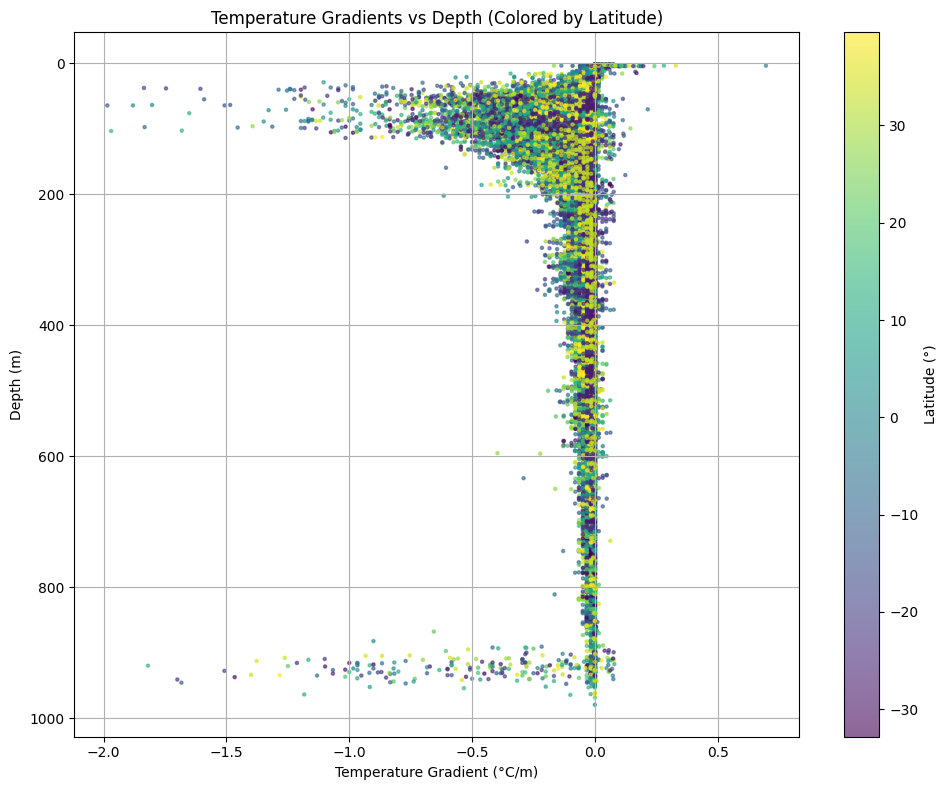

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Prepare gradient, depth, and latitude lists
gradients = []
depths = []
latitudes = []

for df in cleaned_profiles:
    df = df.sort_values('Depth').reset_index(drop=True)
    temp_diff = df['Temp'].diff()
    depth_diff = df['Depth'].diff()
    grad = temp_diff / depth_diff

    gradients.extend(grad[1:])               # skip NaN
    depths.extend(df['Depth'][1:])
    latitudes.extend([df['Latitude'].iloc[0]] * (len(df) - 1))

# Normalize for color mapping
norm = mcolors.Normalize(vmin=min(latitudes), vmax=max(latitudes))
cmap = plt.get_cmap('viridis')
colors = [cmap(norm(lat)) for lat in latitudes]

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(gradients, depths, c=latitudes, cmap=cmap, norm=norm, s=5, alpha=0.6)

plt.gca().invert_yaxis()
plt.xlabel("Temperature Gradient (°C/m)")
plt.ylabel("Depth (m)")
plt.title("Temperature Gradients vs Depth (Colored by Latitude)")

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Latitude (°)")

plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "temperature_gradients_by_depth.png"), dpi=300)
plt.show()

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Load World Ocean Atlas (e.g., annual mean, 0.25°/33 levels)
woa = xr.open_dataset('woa18_decav_t00_04v2.nc')  
# adjust filename/path as needed

# 2. Loop through cleaned profiles, interpolate WOA to profile lat/depth and compute temp difference
diffs = []
for df in cleaned_profiles:
    lat = df['Latitude'].iloc[0]
    temp = df['Temp'].values
    depth = df['Depth'].values

    # Interpolate WOA to profile depth
    woa_t = woa.t_an.mean(dim='time')  # annual mean
    interp_woa = woa_t.interp(lat=lat, lon=-999, depth=depth, method='linear')
    # if lon irrelevant, pick nearest lon slice

    if np.all(np.isfinite(interp_woa)):
        diffs.append(pd.DataFrame({
            'Depth': depth,
            'ΔTemp': temp - interp_woa.values,
            'Latitude': lat
        }))

diff_df = pd.concat(diffs, ignore_index=True)

# 3. Plot ΔT vs depth colored by latitude
norm = mcolors.Normalize(vmin=diff_df['Latitude'].min(), vmax=diff_df['Latitude'].max())
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(10,8))
sc = plt.scatter(diff_df['ΔTemp'], diff_df['Depth'], c=diff_df['Latitude'], cmap=cmap, s=5, alpha=0.6)
plt.gca().invert_yaxis()
plt.axvline(0, color='k', linestyle='--')
plt.colorbar(sc, label='Latitude (°)')
plt.xlabel('ΔT = XBT – WOA (°C)')
plt.ylabel('Depth (m)')
plt.title('Temperature Difference vs Depth (AX08 minus WOA)')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'dT_vs_depth_vs_latitude.png'), dpi=300)
plt.show()

ModuleNotFoundError: No module named 'xarray'

In [2]:
pip install xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [xarray]2m2/3 [xarray]
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import xarray as xr